# Lens modeling with lenstronomy

Author: Tanjela \
Acknowledgement: Nahid

In [ ]:
# import of standard python libraries
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Load imaging data

In [ ]:
with h5py.File("/content/DESIJ1709-3154_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.012138557566447335,
 'dec_at_xy_0': -5.239999999999995,
 'exposure_time': array([[359.87256, 438.06912, 395.772  , ..., 419.91418, 398.95667,
         412.0478 ],
        [514.854  , 544.1436 , 447.31396, ..., 445.43423, 523.56964,
         512.79553],
        [364.70517, 475.4317 , 416.52582, ..., 455.95795, 477.7484 ,
         507.18954],
        ...,
        [541.16736, 482.96542, 453.8767 , ..., 407.2749 , 408.97824,
         413.95084],
        [452.9683 , 439.0108 , 417.46097, ..., 568.15814, 551.5595 ,
         480.95288],
        [293.528  , 306.62485, 420.6663 , ..., 379.75095, 417.29932,
         444.0264 ]], dtype=float32),
 'image_data': array([[ 0.01424764,  0.006525  ,  0.00161528, ...,  0.04487504,
          0.05846716,  0.05135536],
        [ 0.0089196 , -0.01107989, -0.02504737, ...,  0.03001957,
          0.04486683,  0.0455122 ],
        [ 0.01499274,  0.0155811 ,  0.00463138, ...,  0.01737003,
          0.05439983,  0.05461017],
        ...,
   

In [ ]:
with h5py.File("/content/psf_F140W(1).h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

###Visualizing the data

<ipython-input-51-8dfdefc96695>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


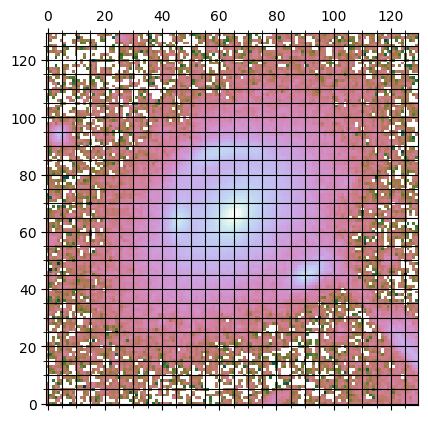

In [ ]:
image_data = kwargs_data["image_data"]
plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.grid(which="both", color="black")
plt.minorticks_on()
plt.grid(which="minor", color="black")
plt.show()

[[ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 ...
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]
 [ 5.24  5.16  5.08 ... -4.92 -5.   -5.08]] [[-5.24 -5.24 -5.24 ... -5.24 -5.24 -5.24]
 [-5.16 -5.16 -5.16 ... -5.16 -5.16 -5.16]
 [-5.08 -5.08 -5.08 ... -5.08 -5.08 -5.08]
 ...
 [ 4.92  4.92  4.92 ...  4.92  4.92  4.92]
 [ 5.    5.    5.   ...  5.    5.    5.  ]
 [ 5.08  5.08  5.08 ...  5.08  5.08  5.08]]


<ipython-input-52-9ea9ebdb9d28>:73: RuntimeWarning: invalid value encountered in log10
  ori = np.log10(kwargs_data["image_data"])
<ipython-input-52-9ea9ebdb9d28>:75: RuntimeWarning: divide by zero encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-52-9ea9ebdb9d28>:75: RuntimeWarning: invalid value encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
<ipython-input-52-9ea9ebdb9d28>:78: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(kwargs_data["image_data"]),


Text(0.5, 1.0, 'Masked image')

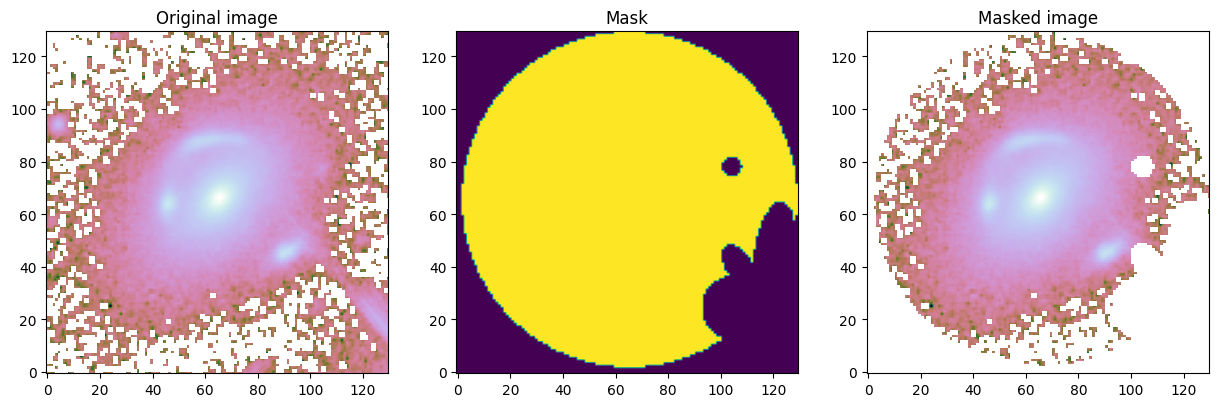

In [ ]:
# To make a likelihood mask using lenstronomy functions,
# here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

print(x_coords, y_coords)

r = 5.1  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.1,
    lens_center_dec + 1,
    0.3,
    0.3,
    0.0,
)


mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.3,
    lens_center_dec - 2.0,
    0.71,
    0.4,
    45,
)

mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.2,
    lens_center_dec - 3.3,
    1.0,
    1,
    15,
)

mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 4.4,
    lens_center_dec - 1.6,
    1.55,
    0.6,
    30,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
)

mask_img = mask.reshape(num_pix, num_pix)


fig, axs = plt.subplots(1, 3, figsize=(15, 10))

ori = np.log10(kwargs_data["image_data"])

masked_img = np.log10(kwargs_data["image_data"] * mask_img)

plt.sca(axs[0])
plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.title("Original image")

plt.sca(axs[1])
plt.imshow(mask_img, origin="lower")
plt.title("Mask")

plt.sca(axs[2])
plt.imshow(masked_img, origin="lower", cmap="cubehelix")
plt.title("Masked image")

## Building the lens model

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

### Mass model of the lens galaxy

In [ ]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# setting EPL parameters
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.5,
        "gamma": 1.8,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1.5,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# Setting SHEAR Parameters
fixed_lens.append({"ra_0": 0, "dec_0": 0})

kwargs_lens_init.append({"gamma1": -0.01, "gamma2": -0.01, "ra_0": 0, "dec_0": 0})

kwargs_lens_sigma.append({"gamma1": 0.1, "gamma2": 0.1, "ra_0": 0, "dec_0": 0})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3, "ra_0": -100, "dec_0": -100})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3, "ra_0": 100, "dec_0": 100})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

###Light model of the lens galaxy

In [ ]:
# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

# 1st sersic

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

# 2nd sersic

fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "amp": 16,
        "R_sersic": 0.5,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0.0,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Light model of the source galaxy

In [ ]:
# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# setting SERSIC_ELLIPSE parameters
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.01,
        "n_sersic": 1.0,
        "e1": 0.0,
        "e2": 0.0,
        "center_x": 0.0,
        "center_y": 0.0,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# setting SHAPELETS parameters
fixed_source.append({"n_max": 8})
kwargs_source_init.append({"beta": 0.03, "center_x": 0.0, "center_y": 0.0})
kwargs_source_sigma.append({"beta": 0.1, "center_x": 0.2, "center_y": 0.2})
kwargs_lower_source.append({"beta": 0.001, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 8, "center_x": 10, "center_y": 10})

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### Combining source and lens models

In [ ]:
# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_source,
}

##Numerical Settings

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

##Model fiting

In [ ]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 200}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.952312607826281 reduced X^2 of best position
-5625.310574429842 log likelihood
11814 effective number of data points
[{'theta_E': 2.001027315701655, 'gamma': 1.950753937467131, 'e1': 0.05872094596645444, 'e2': -0.17409596342423722, 'center_x': 0.013742369829989933, 'center_y': 0.04714920679324771}, {'gamma1': 0.024936603509831883, 'gamma2': 0.024034291229572683, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.28441435701642287, 'n_sersic': 1.0, 'e1': 0.08181642888220363, 'e2': 0.1062362166681676, 'center_x': -0.4275514064367722, 'center_y': -0.1355693120161909}, {'amp': 1, 'n_max': 8, 'beta': 0.08870181603662952, 'center_x': -0.4275514064367722, 'center_y': -0.1355693120161909}] source result
[{'amp': 1, 'R_sersic': 0.1644780360251072, 'n_sersic': 1.0, 'e1': -0.15890420117231954, 'e2': -0.061354270243556185, 'center_x': -0.007189802818316104, 'c

##Visualizing the fitted model

In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1709-3154_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

In [ ]:
### load saved best fit parameters ###

load_output_path = "/content/DESIJ1709-3154_pso_output.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

** Visualizing the fitted model **

-0.946703224819608 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9467032248196063


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


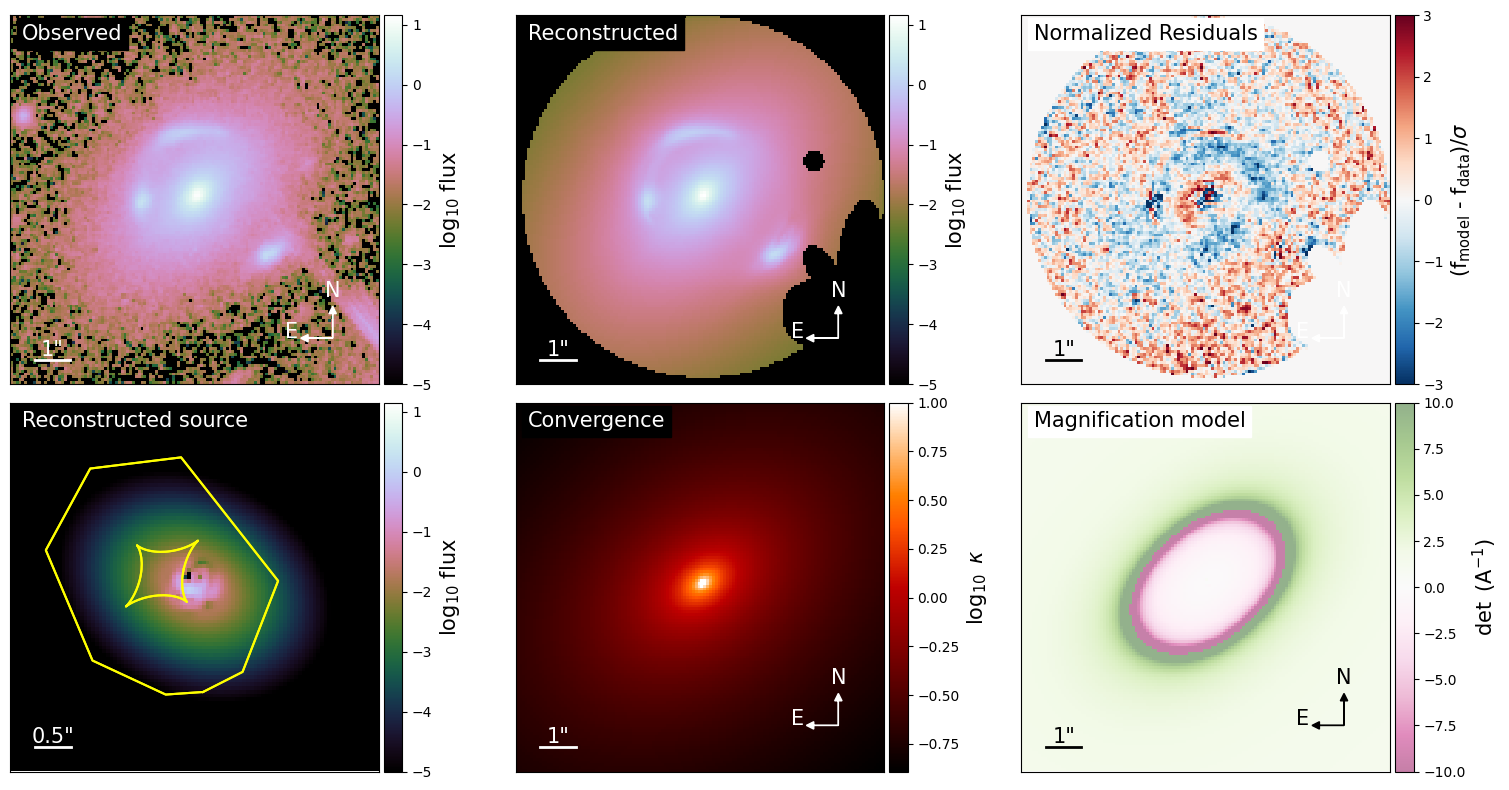

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


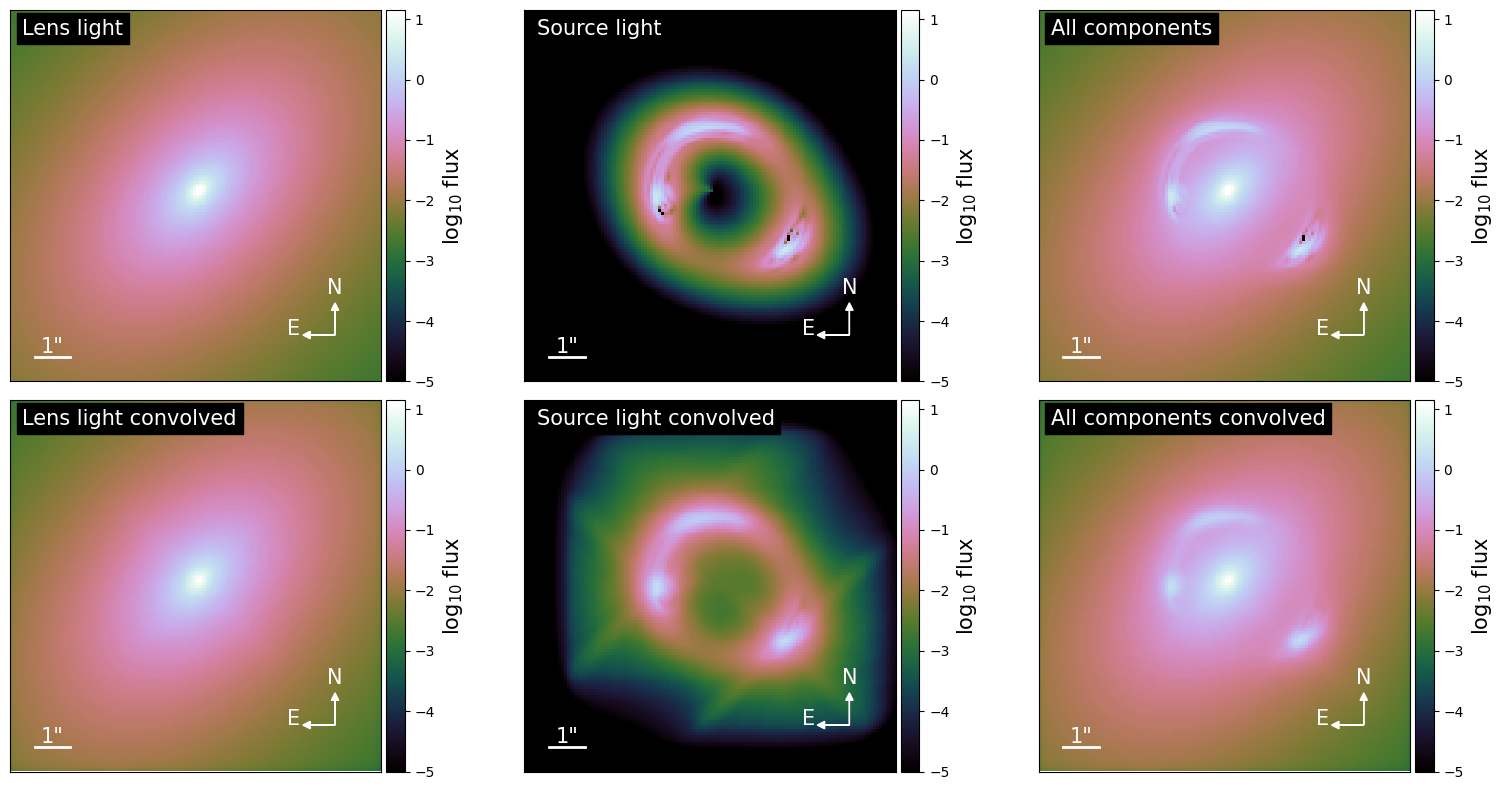

{'kwargs_lens': [{'theta_E': 2.001027315701655, 'gamma': 1.950753937467131, 'e1': 0.05872094596645444, 'e2': -0.17409596342423722, 'center_x': 0.013742369829989933, 'center_y': 0.04714920679324771}, {'gamma1': 0.024936603509831883, 'gamma2': 0.024034291229572683, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 14.56373267502836, 'R_sersic': 0.28441435701642287, 'n_sersic': 1.0, 'e1': 0.08181642888220363, 'e2': 0.1062362166681676, 'center_x': -0.4275514064367722, 'center_y': -0.1355693120161909}, {'amp': array([ 396.30873582,  146.10427097, -226.2181444 ,  127.58195919,
        -73.20199733,  -71.68634265,   18.77080913,  -11.99888926,
        -58.61038422,   87.12586361,   10.19290988,   31.97972082,
        -28.80963835,   50.83305469,   14.98287269,   -5.17291701,
         55.21761562,   12.7920877 ,    3.84709533,   18.8530778 ,
        -53.63130355,   25.6014192 ,   52.90875736,   23.71963487,
        -18.23272041,   11.14392002,  -42.91302435,   -1.06393823,
        -26.0967416

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, with_caustics=True, scale_size=0.5, numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)